# Particle identification

This assignment aims to learn how to define and run deep-learning methods for particle identification of neutrino events. In the last machine-learning lecture, we implemented a number of classification models using standard machine-learning methods (i.e., logistic regression and decision trees). However, we will use deep learning for this assignment instead, which consists of complex artificial neural networks.

##Prerequisites

Let's start with turning on the GPU (if available):

```
Edit -> Notebook settings -> Hardware accelerator: GPU -> Save.
```



Download the dataset, as well as load the needed Python packages and modules:

In [ ]:
!wget "https://raw.githubusercontent.com/saulam/neutrinoml/main/modules.py"
!wget "https://raw.githubusercontent.com/saulam/neutrinoml/main/df_pgun_teaching.p"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import scale
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from modules import *

--2021-12-12 21:45:01--  https://raw.githubusercontent.com/saulam/neutrinoml/main/modules.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9617 (9.4K) [text/plain]
Saving to: ‘modules.py’

modules.py          100%[===================>]   9.39K  --.-KB/s    in 0s      

2021-12-12 21:45:01 (58.6 MB/s) - ‘modules.py’ saved [9617/9617]

--2021-12-12 21:45:01--  https://raw.githubusercontent.com/saulam/neutrinoml/main/df_pgun_teaching.p
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 79089990 (75M) [application/octet-stream]
Saving 

Check whether the GPU was found:

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


##Dataset

We can now load the dataset:

In [ ]:
# read dataframe
df = pd.read_pickle('df_pgun_teaching.p')

We may have a look at the dataset. It consists of 59,578 particle gun events ([from the SFGD detector](https://doi.org/10.1088/1748-0221/15/12/p12003)) with the following attributes:

- **TruePID**: PDG code for particle identification (PID); 2212 (proton), 13 (muon), 211 (pion).
- **TrueMomentum**: momentum in MeV.
- **NNodes**: number of nodes of the event (3D spatial points).
- **NodeOrder**: order of the nodes within the event.
- **NodePosX**: array with the coordinates of the nodes along the X-axis (in mm).
- **NodePosY**: array with the coordinates of the nodes along the Y-axis (in mm).
- **NodePosZ**: array with the coordinates of the nodes along the Z-axis (in mm).
- **NodeT**: array with the timestamps of the nodes (in ms).
- **Nodededx**: array with energy deposits of the nodes (dE/dx).
- **TrkLen**: length of the track (in mm).
- **TrkEDepo**: total track energy deposition (in arbitrary unit).
- **TrkDir1**: track direction, polar angle (in degrees).
- **TrkDir2**: track direction, azimuth angle (in degrees).


In [ ]:
df

,TruePID,TrueMomentum,NNodes,NodeOrder,NodePosX,NodePosY,NodePosZ,NodeT,Nodededx,TrkLen,TrkEDepo,TrkDir1,TrkDir2
0,13,183.392853,24,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[562.3175048828125, 551.2816162109375, 541.041...","[-111.6478500366211, -115.0490493774414, -116....","[-1320.262451171875, -1309.0963134765625, -129...","[2407.756591796875, 2407.81689453125, 2407.876...","[165.22618103027344, 155.27743530273438, 476.1...",356.045837,9982.164062,0.654334,-0.231817
1,13,135.433670,14,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]","[827.2332763671875, 837.4697875976562, 847.938...","[253.38917541503906, 253.08900451660156, 252.9...","[-2185.638916015625, -2184.589599609375, -2183...","[3011.9111328125, 3012.093994140625, 3012.2770...","[314.21441650390625, 362.3026428222656, 291.91...",162.465469,5904.937500,0.087968,-0.100574
2,13,339.641693,93,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[-563.5917358398438, -567.0311889648438, -570....","[104.8846664428711, 105.00057220458984, 105.52...","[-2781.479248046875, -2774.258056640625, -2759...","[1265.9661865234375, 1266.010009765625, 1266.0...","[148.050537109375, 211.795654296875, 216.69546...",1045.475098,25179.537109,0.958850,0.208432
3,13,148.852753,16,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[-21.61979866027832, -26.758699417114258, -32....","[200.89085388183594, 197.64401245117188, 193.9...","[-1263.1961669921875, -1247.6337890625, -1238....","[2434.428466796875, 2434.522705078125, 2434.61...","[324.8998718261719, 334.5282287597656, 236.333...",210.668701,7044.659180,0.898544,-0.520376
4,13,208.717072,34,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[-758.3839721679688, -744.0172119140625, -732....","[-36.68516540527344, -36.56645584106445, -36.5...","[-1941.163330078125, -1936.1429443359375, -193...","[2449.047607421875, 2449.087646484375, 2449.12...","[435.62548828125, 263.379150390625, 228.392959...",406.812988,12549.727539,0.391959,-0.004267
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59573,2212,507.573883,8,"[0, 1, 2, 3, 4, 5, 6, 7]","[580.9529418945312, 586.7144775390625, 591.494...","[159.6537628173828, 148.2635498046875, 135.815...","[-1313.0634765625, -1303.78466796875, -1292.29...","[3025.43115234375, 3025.369384765625, 3025.307...","[1443.2392578125, 1123.779052734375, 1469.8662...",115.832092,8642.566406,0.601480,-0.920192
59574,2212,352.309052,1,[0],[-669.6401977539062],[-102.67927551269531],[-2453.0615234375],[2412.013671875],[22.722021102905273],31.792725,22.722021,0.337339,-0.392731
59575,2212,640.505066,19,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[-360.1888427734375, -354.10491943359375, -348...","[104.60367584228516, 108.55897521972656, 114.6...","[-1302.969970703125, -1292.6866455078125, -127...","[100.14892578125, 100.269287109375, 100.389640...","[326.5594482421875, 1124.9525146484375, 394.84...",257.413971,16223.990234,0.841636,0.657302
59576,2212,559.154297,12,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]","[323.822509765625, 313.666015625, 302.98873901...","[-30.165552139282227, -31.712827682495117, -34...","[-2451.083251953125, -2446.32470703125, -2441....","[1843.7156982421875, 1843.811279296875, 1843.9...","[664.553466796875, 809.3343505859375, 655.9212...",156.982391,11960.110352,0.397594,-0.129663


And check the correlations of the variables (please notice that the node features are not included since each even has a different length):

In [ ]:
df.corr()

,TruePID,TrueMomentum,NNodes,TrkLen,TrkEDepo,TrkDir1,TrkDir2
TruePID,1.000000,0.850428,-0.119319,-0.120292,0.295550,-0.008871,-0.015841
TrueMomentum,0.850428,1.000000,0.330657,0.337742,0.727587,0.044745,-0.006422
NNodes,-0.119319,0.330657,1.000000,0.989437,0.845660,0.097393,0.031975
TrkLen,-0.120292,0.337742,0.989437,1.000000,0.858516,0.110516,0.031158
TrkEDepo,0.295550,0.727587,0.845660,0.858516,1.000000,0.101672,0.014638
TrkDir1,-0.008871,0.044745,0.097393,0.110516,0.101672,1.000000,0.001564
TrkDir2,-0.015841,-0.006422,0.031975,0.031158,0.014638,0.001564,1.000000


The 3D spatial points of the events are usually stored in the form of hits or nodes. We chose the latter for our dataset. A hit corresponds with a cube with real energy deposition (there are usually many hits across the track signature), whilst a node corresponds with a fitted position after performing the track reconstruction.

<div>
<img src="https://raw.githubusercontent.com/saulam/neutrinoml/main/hit.png" width="400"/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
<img src="https://raw.githubusercontent.com/saulam/neutrinoml/main/node.png" width="400"/>
</div>

We may also have a look at the events by plotting the nodes within the detector space. By default, we're looking at the first event (event 0), but we can display more events by playing with the variable `event_number`.

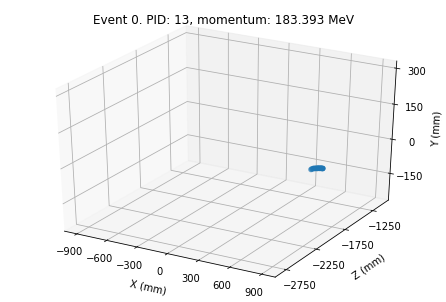

In [ ]:
event_number = 0
plot_event(df, event_number)

Regardless of the type of data we use and the algorithm chosen, it is essential to perform a **preprocessing** of the data, which allows us to prepare the data to make it understandable for the machine-learning algorithm.

As explained before, the goal is to learn to predict a label **y** from a fixed-size vector of features **X**. However, the input data is in 3D, and every event (track) has a different size. Thus, a simple way of doing it is to use two of the features to start with: `TrkLen` and `TrkEDepo`. Please, notice that we are encoding the PID code from protons (2212), muons (13), and pions (211) into 0, 1, and 2, respectively.

In [ ]:
X = np.zeros(shape=(len(df),2), dtype=np.float32) # array of size (n_events, 2)
y = np.zeros(shape=(len(df),), dtype=np.float32)  # array of size (n_events,)

# fill dataset
for event_n, event in df.iterrows():
    
    pid_label = event['TruePID']
    
    # retrieve the first node
    X[event_n, 0] = event['TrkLen']
    X[event_n, 1] = event['TrkEDepo']

    # PID label
    if pid_label==2212: 
      pid_label=0 # proton
    elif pid_label==13: 
      pid_label=1 # muons
    else:
      pid_label=2 # pions
    y[event_n] = pid_label

# standardize the dataset (mean=0, std=1)
X_stan = scale(X)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:236: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  "Numerical issues were encountered "
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:255: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  "Numerical issues were encountered "


In order to understand the training data, it's always good to visualise first. For simplicity, let's start comparing protons and muons (ignoring pions). A good way of doing it is to create a scatter plot of one feature against the other:

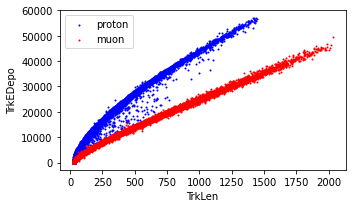

In [ ]:
param_names = ['TrkLen', 'TrkEDepo']
y_names = ['proton', 'muon']

plot_params_pid(X[y!=2], y[y!=2], param_names, y_names)

Good! It's easy to distinguish by eye two "almost" independent distributions: one for protons and the other for muons.

## Fully connected neural networks

Training a machine-learning algorithm is usually not an easy task. The algorithm learns from some training data until it is ready to make predictions on unseen data. In order to test how the algorithm performs on new data, the dataset used for training is divided into two groups (sometimes is divided into three groups, but we're keeping two groups here for simplicity):

- Training set: the model learns from this set only. It must be the largest set.
- Test set: it is used to evaluate the model at the end of the training, only once it is fully trained. 

In this example, we keep 60% of the data for training and 40% for testing. Besides, it's always recommended to shuffle the training examples to prevents any bias during the training.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_stan[y!=2], y[y!=2], test_size=0.4, random_state=7) # random shuffle and split: 60% training, 40% test

This assignment aims to deal with deep learning methods, a subset of machine learning consisting of artificial neural networks. We will implement the fully connected neural network (i.e., all neurons in one layer are connected to all the neurons in the next layer) shown below using the Keras interface from the TensorFlow deep-learning framework. Keras is an API ideal for neural-network prototyping. In the architecture below, each neuron must compute the following function $\sigma(w x + b) < 0.5$, where $w$ and $b$ are the input weight and bias of the neuron, respectively, and $\sigma$ is the [activation function](https://towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6).

<div>
<img src="https://raw.githubusercontent.com/saulam/neutrinoml/main/dense_nn.png" width="700"/>
</div>


In [ ]:
tf.random.set_seed(7) # for reproducibility

num_features = 2 # TrkLen, TrkEDepo
num_classes = 1 # one output unit is enough since it's a binary classification problem

# Fully connected neural network model
input = Input(shape=(num_features,)) # input layer
x = Dense(10, activation='relu')(input) # hidden layer 1
x = Dense(10, activation='relu')(x) # hidden layer 2
output = Dense(num_classes, activation='sigmoid')(x) # output layer
model = Model(inputs=input, outputs=output)

# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 10)                30        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 151
Trainable params: 151
Non-trainable params: 0
_________________________________________________________________


And train the model for 10 epochs and a batch size of 128:

*   Batch: a set of $n$ input examples (also called mini-batch). The input examples in a batch are processed independently, in parallel. During training, a batch results in only one update to the model (one forward pass and one backward pass).
*   Epoch: one forward pass and one backward pass of all the training examples. In other words, an epoch is one pass over the entire dataset, and it is used to separate training into distinct phases. For a dataset consisting of $m$ training examples and a batch size of $n$, then it will take $m / n$ iterations to complete one epoch.


In [ ]:
model.fit(X_train, y_train, epochs=10, batch_size=128, verbose=1)

Epoch 1/10
199/199 [==============================] - 3s 4ms/step - loss: 0.5901 - accuracy: 0.7740
Epoch 2/10
199/199 [==============================] - 1s 4ms/step - loss: 0.2503 - accuracy: 0.9682
Epoch 3/10
199/199 [==============================] - 1s 4ms/step - loss: 0.1246 - accuracy: 0.9715
Epoch 4/10
199/199 [==============================] - 1s 4ms/step - loss: 0.0996 - accuracy: 0.9727
Epoch 5/10
199/199 [==============================] - 1s 4ms/step - loss: 0.0893 - accuracy: 0.9743
Epoch 6/10
199/199 [==============================] - 1s 4ms/step - loss: 0.0836 - accuracy: 0.9749
Epoch 7/10
199/199 [==============================] - 1s 4ms/step - loss: 0.0792 - accuracy: 0.9757
Epoch 8/10
199/199 [==============================] - 1s 4ms/step - loss: 0.0758 - accuracy: 0.9763
Epoch 9/10
199/199 [==============================] - 1s 4ms/step - loss: 0.0737 - accuracy: 0.9764
Epoch 10/10
199/199 [==============================] - 1s 4ms/step - loss: 0.0717 - accuracy: 0.9762

It's also usual to calculate some metrics to evaluate our deep-learning method's performance on the test set.

In [ ]:
y_pred = model.predict(X_test).round()
print("Overall accuracy: {:2.3}\n".format(accuracy_score(y_test, y_pred)))
print(" - Proton accuracy: {:2.3}".format(accuracy_score(y_test[y_test==0], y_pred[y_test==0])))
print(" - Muon accuracy: {:2.3}\n".format(accuracy_score(y_test[y_test==1], y_pred[y_test==1])))
conf=confusion_matrix(y_pred, y_test)
print_conf(conf, ['protons', 'muons'])

Overall accuracy: 0.978

 - Proton accuracy: 0.962
 - Muon accuracy: 0.996

		True protons	True muons
Pred protons	        8630	        35
Pred muons	         338	      7976


Nice! We're getting almost perfect separation using only two input parameters! With logistic regression (first lecture), proton accuracy was similar, but the muon accuracy it was ~83%. The improvement using neural networks is obvious.

Is there any room for improving the current results? 

In the same way we did in the previous lecture, a more robust but straightforward way of making the input data interpretable for the algorithm is to keep the information of only a few nodes of each track. Our preprocessing is illustrated in the following figure (there are many combinations, we are showing just one practical example here):

<div>
<img src="https://raw.githubusercontent.com/saulam/neutrinoml/main/reg.png" width="500"/>
</div>

where we keep the dE/dx of the first 3 and last 5 nodes of each track, along with their 4 global parameters, building up an array of size 12. For events where the track has less than 8 nodes (first 3 + last 5 nodes), we simply fill the empty positions of the array with -1s.

To sum up, with this preprocessing, we should end up having our input dataset **X**, consisting of 59,578 vectors of size 12 each (a 59,578x12 matrix). The values to estimate, **y**, are the labels of each event (proton or muon).

In [ ]:
X = np.zeros(shape=(len(df),12), dtype=np.float32) # array of size (n_event, 12)
y = np.zeros(shape=(len(df),), dtype=np.float32)   # array of size (n_event,)
X.fill(-1) # filled with -1s

# fill dataset
for event_n, event in df.iterrows():

    NodeOrder = event['NodeOrder']
    Nodededx = event['Nodededx'][NodeOrder]

    # retrieve up to the first 3 nodes
    nfirstnodes = min(Nodededx.shape[0], 3)
    X[event_n,:nfirstnodes] = Nodededx[:nfirstnodes]

    if Nodededx.shape[0]>nfirstnodes:
        # retrieve up to the last 5 nodes
        nlastnodes = min(Nodededx.shape[0]-3, 5)
        X[event_n,nfirstnodes:nfirstnodes+nlastnodes] = Nodededx[-nlastnodes:]

    # global parameters
    X[event_n,-4] = event['TrkLen']
    X[event_n,-3] = event['TrkEDepo']
    X[event_n,-2] = event['TrkDir1']
    X[event_n,-1] = event['TrkDir2']

    # PID label
    pid_label = event['TruePID']
    if pid_label==2212:
      pid_label=0 # protons
    elif pid_label==13: 
      pid_label=1 # muons
    else:
      pid_label=2 # pions
    y[event_n] = pid_label
    y[event_n] = pid_label

# standardize the dataset (mean=0, std=1)
X_stan = scale(X)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:236: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  "Numerical issues were encountered "
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:255: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  "Numerical issues were encountered "


In order to understand the training data, it's always good to visualise first. A good way of doing it could be creating a histogram plot of each of our 12 features:

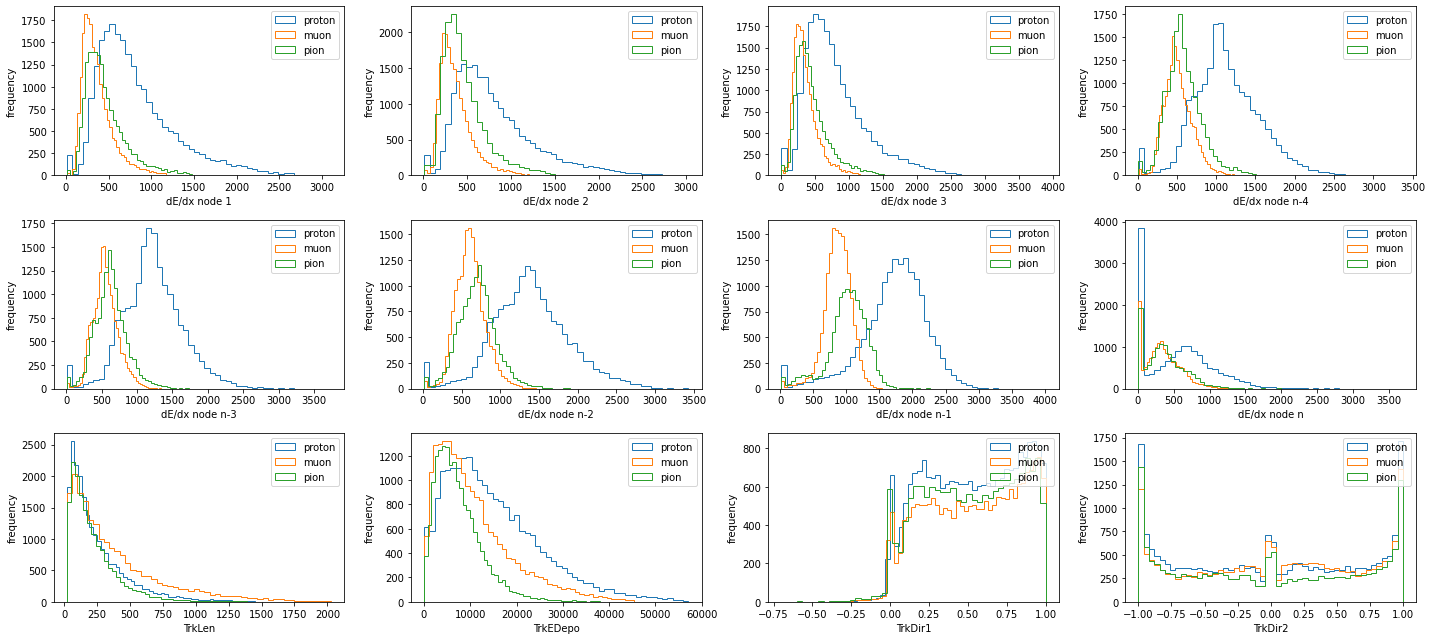

In [ ]:
param_names = ['dE/dx node 1', 'dE/dx node 2', 'dE/dx node 3', 'dE/dx node n-4',\
               'dE/dx node n-3', 'dE/dx node n-2', 'dE/dx node n-1', 'dE/dx node n', 'TrkLen',\
               'TrkEDepo', 'TrkDir1', 'TrkDir2']
y_names = ["proton", "muon","pion"]
plot_parameters(X, y, param_names, y_names, mode="classification")

We split the dataset again into training and test sets:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_stan[y!=2], y[y!=2], test_size=0.4, random_state=7) # 60% training and 40% test

Define a new network (we just need to fix the input layer), train it on the new dataset and test it:

In [ ]:
tf.random.set_seed(7) # for reproducibility

num_features = 12 # TrkLen, TrkEDepo
num_classes = 1 # one output unit is enough since it's a binary classification problem

# Fully connected neural network model
input = Input(shape=(num_features,)) # input layer
x = Dense(10, activation='relu')(input) # hidden layer 1
x = Dense(10, activation='relu')(x) # hidden layer 2
output = Dense(num_classes, activation='sigmoid')(x) # output layer
model = Model(inputs=input, outputs=output)

# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# train the model
model.fit(X_train, y_train, epochs=10, batch_size=128, verbose=1)

# test the model
y_pred = model.predict(X_test).round()
print("Overall accuracy: {:2.3}\n".format(accuracy_score(y_test, y_pred)))
print(" - Proton accuracy: {:2.3}".format(accuracy_score(y_test[y_test==0], y_pred[y_test==0])))
print(" - Muon accuracy: {:2.3}\n".format(accuracy_score(y_test[y_test==1], y_pred[y_test==1])))
conf=confusion_matrix(y_pred, y_test)
print_conf(conf, ['protons', 'muons'])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 12)]              0         
                                                                 
 dense_3 (Dense)             (None, 10)                130       
                                                                 
 dense_4 (Dense)             (None, 10)                110       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 251
Trainable params: 251
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
199/199 [==============================] - 1s 4ms/step - loss: 0.4998 - accuracy: 0.7872
Epoch 2/10
199/199 [==============================] - 1s 4ms/step - loss: 0.1501 - accuracy: 

The results are amazing! However, we have solved a binary classification problem, while our dataset has a third type of particles that we have ignored (pions). Out network architecture is easily extensible to solve problems with a number of classes $k>2$.



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_stan, y, test_size=0.4, random_state=7) # 60% training and 40% test

In [ ]:
tf.random.set_seed(7) # for reproducibility

num_features = 12 # TrkLen, TrkEDepo
num_classes = 3 # proton, muon, and pion

# Fully connected neural network model
input = Input(shape=(num_features,)) # input layer
x = Dense(10, activation='relu')(input) # hidden layer 1
x = Dense(10, activation='relu')(x) # hidden layer 2
output = Dense(num_classes, activation='softmax')(x) # output layer
model = Model(inputs=input, outputs=output)

# compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# train the model
model.fit(X_train, y_train, epochs=10, batch_size=128, verbose=1)

# test the model
y_pred = model.predict(X_test).argmax(axis=1)
print("Overall accuracy: {:2.3}\n".format(accuracy_score(y_test, y_pred)))
print(" - Proton accuracy: {:2.3}".format(accuracy_score(y_test[y_test==0], y_pred[y_test==0])))
print(" - Muon accuracy: {:2.3}".format(accuracy_score(y_test[y_test==1], y_pred[y_test==1])))
print(" - Pion accuracy: {:2.3}\n".format(accuracy_score(y_test[y_test==2], y_pred[y_test==2])))
conf=confusion_matrix(y_pred, y_test)
print_conf(conf, ['protons', 'muons', 'pions'])

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 12)]              0         
                                                                 
 dense_6 (Dense)             (None, 10)                130       
                                                                 
 dense_7 (Dense)             (None, 10)                110       
                                                                 
 dense_8 (Dense)             (None, 3)                 33        
                                                                 
Total params: 273
Trainable params: 273
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
280/280 [==============================] - 1s 3ms/step - loss: 0.7488 - accuracy: 0.6329
Epoch 2/10
280/280 [==============================] - 1s 3ms/step - loss: 0.4857 - accuracy: 

The muon/pion separation looks much better than for decision trees (last lecture)!

The way to add more capacity to our model (making it more capable to learn) is to add more layers and neurons per layer!

In [ ]:
tf.random.set_seed(7) # for reproducibility

num_features = 12 # TrkLen, TrkEDepo
num_classes = 3 # proton, muon, and pion

# Fully connected neural network model
input = Input(shape=(num_features,)) # input layer
x = Dense(100, activation='relu')(input) # hidden layer 1
x = Dense(100, activation='relu')(x) # hidden layer 2
x = Dense(100, activation='relu')(x) # hidden layer 2
x = Dense(100, activation='relu')(x) # hidden layer 2
output = Dense(num_classes, activation='softmax')(x) # output layer
model = Model(inputs=input, outputs=output)

# compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# train the model
model.fit(X_train, y_train, epochs=10, batch_size=128, verbose=1)

# test the model
y_pred = model.predict(X_test).argmax(axis=1)
print("Overall accuracy: {:2.3}\n".format(accuracy_score(y_test, y_pred)))
print(" - Proton accuracy: {:2.3}".format(accuracy_score(y_test[y_test==0], y_pred[y_test==0])))
print(" - Muon accuracy: {:2.3}".format(accuracy_score(y_test[y_test==1], y_pred[y_test==1])))
print(" - Pion accuracy: {:2.3}\n".format(accuracy_score(y_test[y_test==2], y_pred[y_test==2])))
conf=confusion_matrix(y_pred, y_test)
print_conf(conf, ['protons', 'muons', 'pions'])

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 12)]              0         
                                                                 
 dense_9 (Dense)             (None, 100)               1300      
                                                                 
 dense_10 (Dense)            (None, 100)               10100     
                                                                 
 dense_11 (Dense)            (None, 100)               10100     
                                                                 
 dense_12 (Dense)            (None, 100)               10100     
                                                                 
 dense_13 (Dense)            (None, 3)                 303       
                                                                 
Total params: 31,903
Trainable params: 31,903
Non-trainable

## Convolutional neural networks

[Convolutional neural network (CNN)](https://direct.mit.edu/neco/article-abstract/1/4/541/5515/Backpropagation-Applied-to-Handwritten-Zip-Code?redirectedFrom=fulltext) algorithms that operate on images have been very successful in a number of [HEP tasks](https://iml-wg.github.io/HEPML-LivingReview/). The main feature of CNNs is that they apply a series of filters (using convolutions, hence the name of the CNN), usually followed by spatial pooling, applied in sequence to extract increasingly powerful and abstract features that allow the CNN to classify the images [[citation](http://dl.acm.org/citation.cfm?id=2999134.2999257)]. Each of the filters consists of a set of values that are learnt by the CNN through the training process.  CNNs are typically deep neural networks that consist of many convolutional layers, with the output from one convolutional layer forming the input to the next. The last layers of a CNN are usually fully connected layers, where the output layer is followed by a sigmoid or softmax activation function.

Since CNNs learn from images, let's generate a 2D image for each event in the dataset. An easy way of doing it is to save the YZ projection of each 3D event (the projection chosen is not completely arbitrary. We wanted to keep the Z-axis since it corresponds to the beam direction):

In [ ]:
def map_value(y,z):
  min_y = -257.56
  max_y = 317.56
  min_z = -2888.78
  max_z = -999.1

  y = int((y-min_y)//10)
  z = int((z-min_z)//10)

  return y, z


X = np.zeros(shape=(len(df),58,189,1), dtype=np.float32) # array of size (n_event, 56, 184)
y = np.zeros(shape=(len(df),), dtype=np.float32)   # array of size (n_event,)

# fill dataset
for event_n, event in df.iterrows():

    NodePosY = event['NodePosY']
    NodePosZ = event['NodePosZ']
    Nodededx = event['Nodededx']

    old_y, old_z, dedxs = -1, -1, []
    for index in range(len(NodePosY)):
        y_coord, z_coord = NodePosY[index], NodePosZ[index]
        y_coord, z_coord = map_value(y_coord, z_coord)

        if index==0 or (y_coord==old_y and z_coord==old_z):
            dedxs.append(Nodededx[index])
            old_y, old_z = y_coord, z_coord
        else:
            X[event_n, old_y, old_z, 0] = np.mean(dedxs)
            old_y, old_z, dedxs = y_coord, z_coord, []
            dedxs.append(Nodededx[index])

    X[event_n, old_y, old_z, 0] = np.mean(dedxs)

    # PID label
    pid_label = event['TruePID']
    if pid_label==2212:
      pid_label=0 # protons
    elif pid_label==13: 
      pid_label=1 # muons
    else:
      pid_label=2 # pions
    y[event_n] = pid_label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=7) # 60% training and 40% test

We may plot two different views of the same 3D event and the corresponding YZ projection to check everything worked as expected:

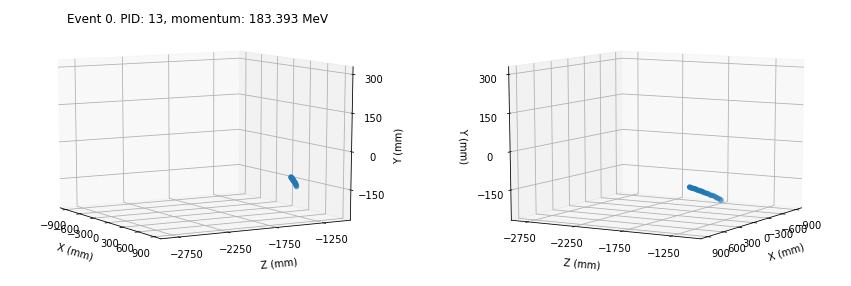

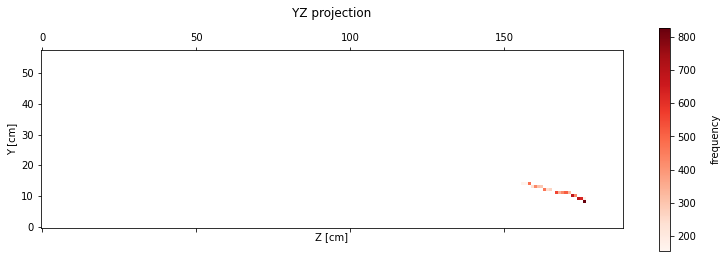

In [ ]:
event_number = 0
plot_projection(df, event_number, X)

We will implement the following convolutional connected neural network:

<div>
<img src="https://raw.githubusercontent.com/saulam/neutrinoml/main/cnn.png" width="900"/>
</div>

In [ ]:
tf.random.set_seed(7) # for reproducibility

# Convolutional neural network model
inp_shape = (58,189,1)
input = Input(shape=inp_shape) # input layer
x = Conv2D(16, (6,18), padding='valid', strides=(2,3), activation='relu')(input) # conv layer 1
x = MaxPooling2D(pool_size=(2,3), strides=(2,3))(x) # max-pooling 1
x = Conv2D(32, (3,3), padding='valid', strides=(2,3), activation='relu')(x) # conv layer 2
x = MaxPooling2D(pool_size=(2,3), strides=(2,3))(x) # max-pooling 2
x = Flatten()(x) # from 3D to 1D
x = Dense(64, activation='relu')(x) # fully connected layer at the end
output = Dense(3, activation='softmax')(x) # output layer

# compile the model
model = Model(inputs=input, outputs=output)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 58, 189, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 27, 58, 16)        1744      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 19, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 6, 6, 32)          4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 2, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 192)               0   

In [ ]:
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=128, verbose=1)

# test the model
y_pred = model.predict(X_test).argmax(axis=1)
print("Overall accuracy: {:2.3}\n".format(accuracy_score(y_test, y_pred)))
print(" - Proton accuracy: {:2.3}".format(accuracy_score(y_test[y_test==0], y_pred[y_test==0])))
print(" - Muon accuracy: {:2.3}".format(accuracy_score(y_test[y_test==1], y_pred[y_test==1])))
print(" - Pion accuracy: {:2.3}\n".format(accuracy_score(y_test[y_test==2], y_pred[y_test==2])))
conf=confusion_matrix(y_pred, y_test)
print_conf(conf, ['protons', 'muons', 'pions'])

Epoch 1/10
280/280 [==============================] - 11s 12ms/step - loss: 1.5426 - accuracy: 0.4040
Epoch 2/10
280/280 [==============================] - 3s 11ms/step - loss: 0.9344 - accuracy: 0.5246
Epoch 3/10
280/280 [==============================] - 3s 11ms/step - loss: 0.7713 - accuracy: 0.6232
Epoch 4/10
280/280 [==============================] - 3s 11ms/step - loss: 0.6633 - accuracy: 0.6742
Epoch 5/10
280/280 [==============================] - 3s 11ms/step - loss: 0.6084 - accuracy: 0.6972
Epoch 6/10
280/280 [==============================] - 3s 11ms/step - loss: 0.5704 - accuracy: 0.7148
Epoch 7/10
280/280 [==============================] - 3s 11ms/step - loss: 0.5485 - accuracy: 0.7259
Epoch 8/10
280/280 [==============================] - 3s 11ms/step - loss: 0.5350 - accuracy: 0.7327
Epoch 9/10
280/280 [==============================] - 3s 11ms/step - loss: 0.5206 - accuracy: 0.7417
Epoch 10/10
280/280 [==============================] - 3s 11ms/step - loss: 0.5104 - accur

How do we interpret the results? Does it mean CNNs are less powerful than fully connected networks (FCNs)? No! From the physics point of view, we are training the CNN to identify particles but just looking at their signatures in a 2D projection! In contrast, we were giving our FCN as input some reconstructed physics parameters that were useful for performing PID. Thus, the scientist's goal should be to understand which method is best for each situation.

##Homework

It's your time to beat the results above!

The idea is to add capacity to the models by designing wider (more neurons or convolutional filters per layer) and deeper (more layers) networks.

Useful links:

- How to Control Neural Network Model Capacity With Nodes and Layers: https://machinelearningmastery.com/how-to-control-neural-network-model-capacity-with-nodes-and-layers/.
- TensorFlow 2 quickstart for beginners: https://www.tensorflow.org/tutorials/quickstart/beginner.
- Building a Convolutional Neural Network Using TensorFlow – Keras: https://www.analyticsvidhya.com/blog/2021/06/building-a-convolutional-neural-network-using-tensorflow-keras/.